In [23]:
%matplotlib inline
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from keras.datasets import mnist
from random import randint

from matplotlib.pyplot import scatter, imshow

In [213]:
def nshow(img):
    if img.ndim == 4:
        img = img[0]
    if img.ndim == 3:
        img = img[:,:,0]
    plt.imshow(img)
    
    
def oddone(img):
    canvas = np.zeros((56, 56))
    for i, (a, b) in enumerate([(0,0), (0,28), (28,0), (28,28)]):
        canvas[a:a+28, b:b+28] = img[:,:,i]
    plt.imshow(canvas)

In [33]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_shape = x_train[0].shape

x_train = x_train.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train),) + img_shape + (1,))
x_test = x_test.astype('float32') / 255.
# x_test = x_test.reshape((len(x_test),)  + img_shape + (1,))

In [34]:
nums = [x_train[y_train  == i] for i in range(10)]
lens = [len(num) for num in nums]

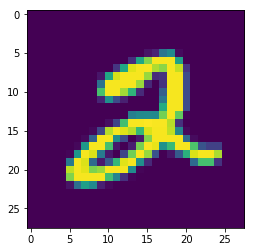

In [35]:
nshow(nums[2][0])

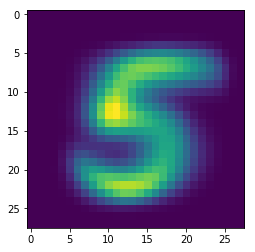

In [36]:
nshow(np.mean(nums[5], axis=0))

In [225]:
def generate_bogies(training_set):
    bogies = []
    for i, x in enumerate(training_set):
        y = y_train[i]
        r_digit = randint(0,9) # bogey number
        while r_digit == y:
            r_digit = randint(0,9) # avoid duplicates
        L = lens[r_digit] - 1 # max index
        n_digits = [randint(0, L) for i in range(3)]
        bogey = [nums[r_digit][n] for n in n_digits]
    #     bogey = np.array(bogey)
    #     bogey = np.swapaxes(bogey, 0,2)
        bogies.append(bogey)
    bogies = np.array(bogies)
    x_train_s = training_set.reshape((len(training_set), -1, 28, 28))[:len(bogies)]
    oot = np.concatenate([x_train_s, bogies], axis=1)
    oot2 = np.moveaxis(oot, 1,3)
    oot3 = np.array([np.roll(frame, randint(0,3), axis=2) for frame in oot2])
    return oot3

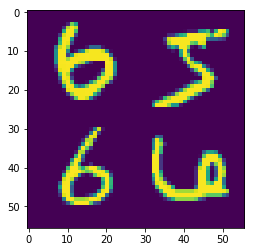

In [234]:
bogies = generate_bogies(x_train)
bogies_test = generate_bogies(x_test)
bogies.shape, bogies_test.shape
oddone(bogies[0])

(10000, 28, 28, 4)


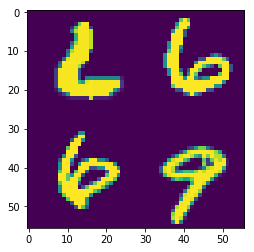

In [255]:

print(bogies_test.shape)
oddone(bogies_test[9])

In [238]:
np.amax(bogies)

1.0

In [237]:
np.save('x_oot_train', bogies)
np.save('x_oot_test', bogies_test)

In [257]:
'''This script demonstrates how to build a variational autoencoder
with Keras and deconvolution layers.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
np.random.seed(1337)
import time
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

from keras_tqdm import TQDMNotebookCallback

In [258]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
original_img_size = x_train[0].shape + (1,)

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

x_train.shape: (60000, 28, 28, 1)


In [263]:
x_oot_train = np.load('x_oot_train.npy')
x_oot_test = np.load('x_oot_test.npy')
print(x_oot_train.shape, x_oot_test.shape)
original_img_size = x_oot_train[0].shape
print(original_img_size)

(60000, 28, 28, 4) (10000, 28, 28, 4)
(28, 28, 4)


In [305]:
beta_kl = K.variable(value=0.0)
beta_xe = K.variable(value=1.0)

# input image dimensions
img_rows, img_cols, img_chns = original_img_size
# number of convolutional filters to use
filters = 64
# convolution kernel size
num_conv = 3

batch_size = 100
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
    print("channel first")
else:
    original_img_size = (img_rows, img_cols, img_chns)
    print("channel last")
latent_dim = 4
intermediate_dim = 128
epsilon_std = 1.0
epochs = 4
conv_act = 'relu'

x = Input(batch_shape=(batch_size,) + original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='elu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='elu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='elu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='elu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='elu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='elu')
decoder_upsample = Dense(filters * 14 * 14, activation='elu')

if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='elu')
decoder_deconv_2 = Conv2DTranspose(filters, num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='elu')
if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='elu')
decoder_mean_squash = Conv2D(1,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)



def vae_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return beta_xe*xent_loss + beta_kl*kl_loss


vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

channel last
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (100, 28, 28, 4)      0                                            
____________________________________________________________________________________________________
conv2d_26 (Conv2D)               (100, 28, 28, 4)      68                                           
____________________________________________________________________________________________________
conv2d_27 (Conv2D)               (100, 14, 14, 64)     1088                                         
____________________________________________________________________________________________________
conv2d_28 (Conv2D)               (100, 14, 14, 64)     36928                                        
______________________________________________________________________________

In [306]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
def plot_latent(encoder, x_test):
    # display a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='Vega10')
    plt.colorbar()
    plt.show()

In [ ]:
K.set_value(beta_xe, 1.0)
K.set_value(beta_kl, 0.0)
start = time.time()
N=60000
vae.fit(x_oot_train[:], x_train[:],
        shuffle=True,
        nb_epoch=5,
        batch_size=batch_size,
        validation_data=(x_oot_test, x_test), 
        callbacks=[TQDMNotebookCallback()], verbose=0)
stop = time.time()
elapsed = stop-start
print("Activation:", conv_act)
print("Process time: {:.2f}, {:.3f}s/epoch".format(elapsed, elapsed/epochs))

/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Activation: relu
Process time: 78.42, 19.604s/epoch


In [ ]:
K.set_value(beta_xe, 1.0)
K.set_value(beta_kl, 0.5)
vae.fit(x_oot_train, x_train[:],
        shuffle=True,
        nb_epoch=5,
        batch_size=batch_size,
        validation_data=(x_oot_test, x_test), 
        callbacks=[TQDMNotebookCallback()], verbose=0)

/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


In [ ]:
K.set_value(beta_xe, 1.0)
K.set_value(beta_kl, 1.0)
vae.fit(x_oot_train, x_train[:],
        shuffle=True,
        nb_epoch=5,
        batch_size=batch_size,
        validation_data=(x_oot_test, x_test), 
        callbacks=[TQDMNotebookCallback()], verbose=0)

In [286]:
pred = vae.predict(x_oot_test, batch_size=batch_size)[:,:,:,0]
print(pred.shape)

(10000, 28, 28)


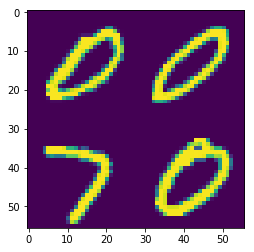

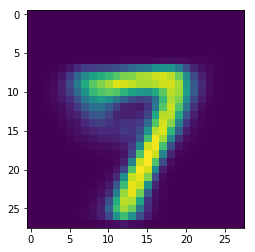

In [300]:
n =17
plt.figure(0)
oddone(x_oot_test[n])
plt.figure(1)
imshow(pred[n])

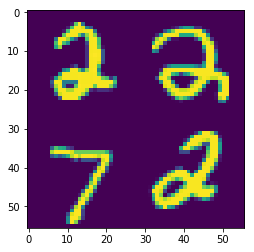

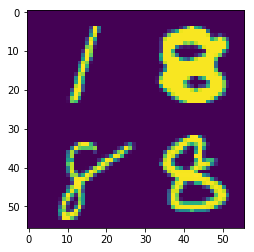

In [288]:
plt.figure(0)
oddone(x_oot_test[0])
plt.figure(1)
oddone(x_oot_test[2])

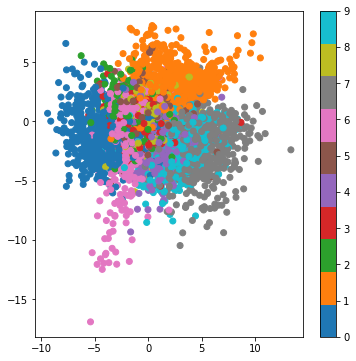

In [304]:
plot_latent(encoder, x_oot_test)

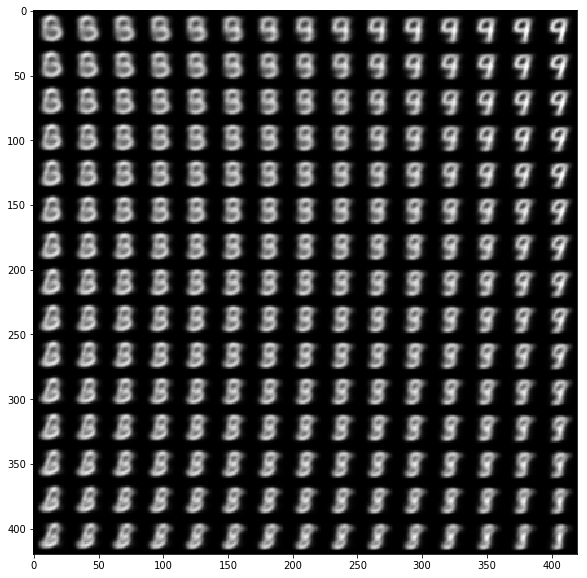

In [301]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()